<a href="https://colab.research.google.com/github/rahulsarkar906/TensorRT_Basics/blob/main/tftrt/examples/image-classification/TFv2-TF-TRT-inference-from-Keras-saved-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TF-TRT Inference from Keras Model with TensorFlow 2.0


## Introduction
The NVIDIA TensorRT is a C++ library that facilitates high performance inference on NVIDIA graphics processing units (GPUs). TensorRT takes a trained network, which consists of a network definition and a set of trained parameters, and produces a highly optimized runtime engine which performs inference for that network. 

TensorFlow™ integration with TensorRT™ (TF-TRT) optimizes and executes compatible subgraphs, allowing TensorFlow to execute the remaining graph. While you can still use TensorFlow's wide and flexible feature set, TensorRT will parse the model and apply optimizations to the portions of the graph wherever possible.

In this notebook, we demonstrate the process of creating a TF-TRT optimized model from a ResNet-50 Keras saved model.

## Requirement

### GPU

Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.

This demo will work on any NVIDIA GPU with CUDA cores, though for improved FP16 and INT8 inference, a Volta, Turing or newer generation GPU with Tensor cores is desired.  On Google Colab, this normally means a T4 GPU. If you are assigned an older K80 GPU, another trial at another time might give you a T4 GPU.


In [3]:
!nvidia-smi

Fri Aug  6 12:32:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow-GPU 2.0

In [3]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

In [4]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.0.0


### Install TensorRT Runtime

In [5]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

(Reading database ... 160858 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Ign:1 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu b

--2021-08-06 12:16:47--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’

     0K ..                                                    100%  163M=0s

2021-08-06 12:16:47 (163 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1

In [6]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                    amd64        TensorRT runtime libraries


A successfull TensorRT installation looks like:

```
TensorRT version: 
ii  libnvinfer5   5.1.5-1+cuda10.1   amd64        TensorRT runtime libraries
```

### Check Tensor core GPU
The below code check whether a Tensor-core GPU is present.

In [7]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


### Importing required libraries

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


## Data
We download several random images for testing from the Internet.

In [9]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘./data’: File exists
--2021-08-06 12:17:47--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.224.2.76, 13.224.2.121, 13.224.2.116, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.224.2.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.001s  

2021-08-06 12:17:47 (21.0 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2021-08-06 12:17:47--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8001::4, 2620:12a:8000::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, awaiting

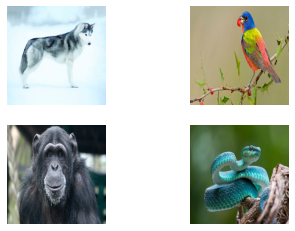

In [11]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

## Model

We next download and test a ResNet-50 pre-trained model from the Keras model zoo.

In [6]:
model = ResNet50(weights='imagenet')

In [13]:
pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 8.1 MB/s 
     |████████████████████████████████| 15.7 MB 118 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.1 which is incompatible.
tensorflo

40960/35363 [==================================] - 0s 0us/step
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951567)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.30138937), ('n01537544', 'indigo_bunting', 0.16979575), ('n01828970', 'bee_eater', 0.16134149)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.51498646), ('n02480495', 'orangutan', 0.15896705), ('n02480855', 'gorilla', 0.15318157)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.43772477), ('n03627232', 'knot', 0.08848065), ('n01749939', 'green_mamba', 0.08080046)]


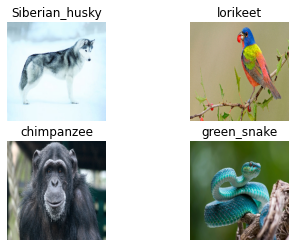

In [7]:
for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])
    

TF-TRT takes input as aTensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

In [8]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [9]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


### Inference with native TF2.0 saved model

In [10]:
model = tf.keras.models.load_model('resnet50_saved_model')

./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.51498723), ('n02480495', 'orangutan', 0.15896682), ('n02480855', 'gorilla', 0.15318121), ('n02484975', 'guenon', 0.09569339), ('n02483708', 'siamang', 0.024028504)]


Text(0.5, 1.0, 'chimpanzee')

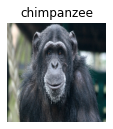

In [13]:
img_path = './data/img2.JPG'  # Siberian_husky
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=5)[0]))
plt.subplot(2,2,1)
plt.imshow(img);
plt.axis('off');
plt.title(decode_predictions(preds, top=3)[0][0][1])

In [14]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [15]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 35.1ms
Step 50: 34.2ms
Step 100: 34.1ms
Step 150: 33.9ms
Step 200: 32.9ms
Step 250: 32.9ms
Step 300: 32.8ms
Step 350: 33.0ms
Step 400: 33.3ms
Step 450: 32.9ms
Step 500: 32.8ms
Step 550: 32.9ms
Step 600: 32.7ms
Step 650: 32.8ms
Step 700: 33.2ms
Step 750: 32.4ms
Step 800: 32.8ms
Step 850: 32.6ms
Step 900: 32.5ms
Step 950: 32.5ms
Throughput: 243 images/s


### TF-TRT FP32 model

We first convert the TF native FP32 model to a TF-TRT FP32 model.

In [16]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [ ]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


Next, we load and test the TF-TRT FP32 model.

In [17]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['probs'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566207), ('n02109961', 'Eskimo_dog', 0.41737258), ('n02110063', 'malamute', 0.020951604)]


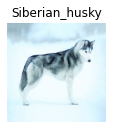

In [18]:
predict_tftrt('resnet50_saved_model_TFTRT_FP32')

In [22]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [23]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

Step 0: 11.2ms
Step 50: 11.1ms
Step 100: 11.1ms
Step 150: 11.1ms
Step 200: 11.1ms
Step 250: 11.1ms
Step 300: 11.1ms
Step 350: 11.1ms
Step 400: 11.1ms
Step 450: 11.1ms
Step 500: 11.1ms
Step 550: 11.1ms
Step 600: 11.1ms
Step 650: 11.1ms
Step 700: 11.1ms
Step 750: 11.1ms
Step 800: 11.1ms
Step 850: 11.1ms
Step 900: 11.1ms
Step 950: 11.1ms
Throughput: 722 images/s


### TF-TRT FP16 model
We next convert the native TF FP32 saved model to TF-TRT FP16 model.

In [24]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662024), ('n02109961', 'Eskimo_dog', 0.417373), ('n02110063', 'malamute', 0.020951627)]


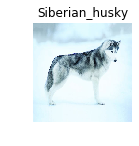

In [ ]:
predict_tftrt('resnet50_saved_model_TFTRT_FP16')

In [25]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')

Step 0: 11.1ms
Step 50: 11.1ms
Step 100: 11.0ms
Step 150: 11.0ms
Step 200: 11.0ms
Step 250: 11.0ms
Step 300: 11.0ms
Step 350: 11.0ms
Step 400: 11.0ms
Step 450: 11.1ms
Step 500: 11.0ms
Step 550: 11.0ms
Step 600: 11.0ms
Step 650: 11.0ms
Step 700: 11.0ms
Step 750: 11.0ms
Step 800: 11.0ms
Step 850: 11.0ms
Step 900: 11.0ms
Step 950: 11.0ms
Throughput: 725 images/s


### TF-TRT INT8 model

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  

Herein, for demonstration purposes, we take only the 4 images that we downloaded for calibration. In production, this set should be more representative of the production data.

Due to Colab memory limit which sometime causes TensorRT to crash, to proceed, first, restart the runtime by pressing CTRL+M or select *Runtime -> Restart runtime...* or simply execute the next cell.

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [3]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='resnet50_saved_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets
Done Converting to TF-TRT INT8


In [4]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['probs'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5505604), ('n02109961', 'Eskimo_dog', 0.42278686), ('n02110063', 'malamute', 0.021412423)]


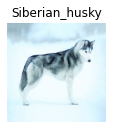

In [5]:
predict_tftrt('resnet50_saved_model_TFTRT_INT8')

In [6]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [7]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8')

Step 0:  6.6ms
Step 50:  6.5ms
Step 100:  6.5ms
Step 150:  6.5ms
Step 200:  6.5ms
Step 250:  6.5ms
Step 300:  6.5ms
Step 350:  6.5ms
Step 400:  6.5ms
Step 450:  6.5ms
Step 500:  6.5ms
Step 550:  6.5ms
Step 600:  6.5ms
Step 650:  6.5ms
Step 700:  6.5ms
Step 750:  6.5ms
Step 800:  6.5ms
Step 850:  6.5ms
Step 900:  6.5ms
Step 950:  6.5ms
Throughput: 1230 images/s


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model, as well as verify their speed and accuracy. 

### What's next
Try TF-TRT on your own model and data, and experience the simplicity and speed up it offers.